# StarcNet demo for NGC1566
This notebook executes a demo with **already downloaded** `.fits` and `.tabs` files saved to folders `legus/frc_fits_files` and `legus/tab_files` respectively.

**Note:** To install the starcnet environment kernel to Jupyter run in your terminal:
```
python -m ipykernel install --user --name starcnet --display-name "starcnet"
```

## Table of contents
* [Getting started](#Getting-started)
* [Create dataset](#Create-dataset)
* [Run StarcNet](#Run-StarcNet)
    * [Load dataset](#Load-dataset)
    * [Classify objects](#Classify-objects)
* [Create text file with predictions](#Create-text-file-with-predictions)
* [Create galaxy image with predictions](#Create-galaxy-image-with-predictions)

## Getting started

In [1]:
import os
import sys
import csv
import time
import pickle
import numpy as np
from numpy.linalg import norm

import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

sys.path.insert(0, './src/utils')
sys.path.insert(0, './model')
from data_utils import load_db
from starcnet import Net

Check that galaxy name and filenames are already in the `.txt` files `targets.txt` and `frc_fits_links.txt`. The complete download link should be added if used with online LEGUS catalogs.

In [2]:
print(open('targets.txt', 'r').read())
print(open('frc_fits_links.txt', 'r').read())

ngc1566

https://archive.stsci.edu/hlsps/legus/ngc1566/ngc1566_drc.tar.gz



## Create dataset
Create a 32x32x5 array per object in the catalog (`.tab` file). Each array is object centered and has the 5 bands of the photometric information from the HST.

In [3]:
print('creating dataset...')
os.system('bash create_dataset.sh')
print('dataset created')

creating dataset...
creating object arrays for galaxies ['ngc1566\n']
creating dataset...
dataset shape: (2752, 5, 32, 32)
dataset created


## Run StarcNet

In [4]:
batch_size = 64 # input batch size for testing (default: 64)
data_dir = 'data/' # dataset directory
dataset = 'raw_32x32' # dataset file reference
checkpoint = 'model/starcnet.pth' # trained model
gpu = '' # CUDA visible device (when using a GPU add GPU id (e.g. '0'))
cuda = False # enables CUDA training (when using a GPU change to True)

### Load dataset

In [5]:
data_all, _, ids = load_db(os.path.join(data_dir,'test_'+dataset+'.dat'))
mean = np.load(os.path.join(data_dir,'mean.npy'))

data_test = data_all - mean[np.newaxis,:,np.newaxis,np.newaxis] # subtract mean

data = torch.from_numpy(data_test).float()
test_loader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=False)

### Classify objects

In [6]:
def L0(x, thresh):

    x_abs = np.abs(x)
    x_large = np.where(x_abs>thresh)

    y = 0
    for i in range(x_large.shape[0]):
        if i == 1:
            if x_large[i]==1:
                y = y + 1
        else:
            if x_large[i]==1 and x_large[i-1]==0:
                y = y + 1
    return y

def entropy1D(X):
    e = 0
    for i in range(X.shape[0]):
        if X[i]>0:
            e = e - (X[i] * np.log(X[i]))
    return e
    
def deterministic_dist(n,mesh_v):
    
    assert n<=5

    targets = np.zeros((n, (mesh_v.shape[0])**n))
    
    if n==1:
        c = 0
        for i1 in mesh_v:
            targets[:,c]=i1
            targets[:,c] = targets[:,c]/norm(targets[:,c],1)
            c = c + 1
    elif n==2:
        c = 0
        for i1 in mesh_v:
            for i2 in mesh_v:
                targets[:,c]=[i1, i2]
                targets[:,c] = targets[:,c]/norm(targets[:,c],1)
                c = c + 1
    elif n==3:
        c = 0
        for i1 in mesh_v:
            for i2 in mesh_v:
                for i3 in mesh_v:
                    targets[:,c]=[i1, i2, i3]
                    targets[:,c] = targets[:,c]/norm(targets[:,c],1)
                    c = c + 1
    elif n==4:
        c = 0
        for i1 in mesh_v:
            for i2 in mesh_v:
                for i3 in mesh_v:
                    for i4 in mesh_v:
                        targets[:,c]=[i1, i2, i3, i4]
                        targets[:,c] = targets[:,c]/norm(targets[:,c],1)
                        c = c + 1
    elif n==5:
        c = 0
        for i1 in mesh_v:
            for i2 in mesh_v:
                for i3 in mesh_v:
                    for i4 in mesh_v:
                        for i5 in mesh_v:
                            targets[:,c]=[i1, i2, i3, i4, i5]
                            targets[:,c] = targets[:,c]/norm(targets[:,c],1)
                            c = c + 1                            
    return targets
    
def predict_OT(image, lambda_v):

    image_width = image.shape[1]
    image_height = image.shape[2]
    source = image[0,:,:].flatten()
    
    n = source.shape[0]
    epsilon = 1.
        
    C = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            (ix, iy) = np.unravel_index(i,(image_width, image_height))
            (jx, jy) = np.unravel_index(j,(image_width, image_height))
            C[i,j] = norm([ix-jx, iy-jy])

    K = np.exp(-C/epsilon)

#     mesh_size = 5
#     mesh_v = np.linspace(0,1,num=mesh_size)
#     targets_size = (mesh_v.shape[0])**n
    targets_size = 100
    
    dist_W = np.zeros((targets_size,lambda_v.shape[0]))
    dist_l1 = np.zeros((targets_size,lambda_v.shape[0]))
    dist_l2 = np.zeros((targets_size,lambda_v.shape[0]))
    target_v = np.zeros((targets_size,lambda_v.shape[0],n))
    target_W_entropy = np.zeros((lambda_v.shape[0]))
    target_W_points = np.zeros((lambda_v.shape[0]))

    for lambda_ind in range(lambda_v.shape[0]):
#         targets = deterministic_dist(n,mesh_v)
#         for rand_ind in range(targets_size):
#             target = targets[:,rand_ind]
        for rand_ind in range(targets_size):
            target = np.random.rand(n)
            target = target/norm(target,1)

            u = np.ones(n)
            v = np.ones(n)
            T = np.diag(u) @ K @ np.diag(v)

            for opt_ind in range(1000):
                u = source/(K @ v)
                v = target/(K.T @ u)
                T = np.diag(u) @ K @ np.diag(v)

            dist_W[rand_ind,lambda_ind] = norm(C * T, 'fro') \
                + lambda_v[lambda_ind]*entropy1D(target)
            dist_l1[rand_ind,lambda_ind] = norm(source-target,1) \
                + lambda_v[lambda_ind]*entropy1D(target)
            dist_l2[rand_ind,lambda_ind] = norm(source-target,2) \
                + lambda_v[lambda_ind]*entropy1D(target)
            target_v[rand_ind,lambda_ind,:] = target.flatten()

        I = np.argmin(dist_W[:,lambda_ind])
        optimal_target = target_v[I,lambda_ind,:]
        target_W_entropy[lambda_ind] = entropy1D(optimal_target)
        target_W_points[lambda_ind] = L0(optimal_target, thresh)
        
    return target_W_points[0]
    
def test_OT(test_loader, predictions_shape, scores_shape, lambda_v):
    predictions = np.zeros(predictions_shape, dtype=np.int64) # placeholder for all predictions
    scores = np.zeros(scores_shape, dtype=np.float32) # placeholder for all scores
    
    data_np = data.numpy()
    for i in range(predictions.shape[0]):
        p = predict_OT(data_np[i,:,:,:], lambda_v)
        if p==1:
            predictions[i] = 0
        else:
            predictions[i] = 1
            
    return predictions, scores

def test(test_loader):
    '''
    Forward pass through the CNN for one epoch
    '''
    model.eval()
    predictions = np.array([], dtype=np.int64).reshape(0) # placeholder for all predictions
    scores = np.array([], dtype=np.float32).reshape(0,4) # placeholder for all scores
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            if cuda:
                data = Variable(data[0].cuda())
            else:
                data = Variable(data[0])
            output = model(data) # forward pass through the CNN
            pred = output.data.max(1)[1] # get the index of the max log-probability
            predictions = np.concatenate((predictions, pred.cpu().numpy()))
            scores = np.concatenate((scores, output.data.cpu().numpy()),axis=0)
    return predictions, scores


def load_weights(model):
    '''
    Load trained parameters to model
    '''
    model_dict = model.state_dict()
    if cuda:
        pretrained_dict = torch.load(checkpoint)
    else:
        pretrained_dict = torch.load(checkpoint, map_location=torch.device('cpu'))
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size() }
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

## Create text file with predictions

In [7]:
start_time = time.time()

cuda = cuda and torch.cuda.is_available()
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

model = Net() # create model with StarcNet architecture
load_weights(model) # load trained model parameters

if cuda:
    model.cuda()

predictions, scores = test(test_loader) # classify all 32x32x5 arrays

np.save(os.path.join('output','scores'), scores) # save scores to 'output/scores.npy' file
print('End of classification | time: %.2fs'%(time.time() - start_time))
print('-'*40)
print('Objects classified as Class 1: %d'%(len(np.where(predictions == 0)[0])))
print('Objects classified as Class 2: %d'%(len(np.where(predictions == 1)[0])))
print('Objects classified as Class 3: %d'%(len(np.where(predictions == 2)[0])))
print('Objects classified as Class 4: %d'%(len(np.where(predictions == 3)[0])))


End of classification | time: 48.64s
----------------------------------------
Objects classified as Class 1: 621
Objects classified as Class 2: 197
Objects classified as Class 3: 240
Objects classified as Class 4: 1694


In [ ]:
print('OT:')
lambda_v = 10.**np.arange(-2,2,.1)
for lambda_ind in range(lambda_v.shape[0]):
    # classify all 32x32x5 arrays
    predictions_OT, scores_OT = test_OT(test_loader, predictions.shape, scores.shape,np.array([lambda_v[lambda_ind]]))
    print('lambda: %f'%lambda_v[lambda_ind])
    print('Objects classified as Class 1: %d'%(len(np.where(predictions_OT == 0)[0])))
    print('Objects classified as Class 2: %d'%(len(np.where(predictions_OT == 1)[0])))
    print('Objects classified as Class 3: %d'%(len(np.where(predictions_OT == 2)[0])))
    print('Objects classified as Class 4: %d'%(len(np.where(predictions_OT == 3)[0])))
    predictions_agree = np.where(predictions == predictions_OT)
    print('Class 1 accuracy: %f'%(len(np.where(predictions[predictions_agree] == 0)[0])/predictions.shape[0]))
    print('Class 2 accuracy: %f'%(len(np.where(predictions[predictions_agree] == 1)[0])/predictions.shape[0]))
    print('Class 3 accuracy: %f'%(len(np.where(predictions[predictions_agree] == 2)[0])/predictions.shape[0]))
    print('Class 4 accuracy: %f'%(len(np.where(predictions[predictions_agree] == 3)[0])/predictions.shape[0]))

OT:


/tmp/ipykernel_13503/1748853628.py:118: RuntimeWarning: overflow encountered in true_divide
  u = source/(K @ v)
/tmp/ipykernel_13503/1748853628.py:119: RuntimeWarning: invalid value encountered in matmul
  v = target/(K.T @ u)
/tmp/ipykernel_13503/1748853628.py:120: RuntimeWarning: invalid value encountered in matmul
  T = np.diag(u) @ K @ np.diag(v)
/tmp/ipykernel_13503/1748853628.py:118: RuntimeWarning: divide by zero encountered in true_divide
  u = source/(K @ v)


In [16]:
with open('data/test_raw_32x32.dat', 'rb') as infile:
    dset = pickle.load(infile)
data, ids, galaxies, coords = dset['data'], dset['ids'], dset['galaxies'], dset['coordinates']

scores = np.load('output/scores.npy')
preds = np.argmax(scores,axis=1)

with open('output/predictions.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['Galaxy', 'Id', 'X', 'Y','Prediction'])
    for i in range(len(ids)):
        filewriter.writerow([galaxies[i], ids[i], coords[i][0], coords[i][1], preds[i]+1])

print("Text file with predictions: 'output/predictions.csv'")

Text file with predictions: 'output/predictions.csv'


## Create galaxy image with predictions

In [17]:
os.system('python src/run_visualization.py')

print("Image with predictions saved to 'output/visualizations/' folder")

creating ngc1566 visualization...
visualization saved to 'output/visualizations/ngc1566_predictions.png'
Image with predictions saved to 'output/visualizations/' folder


## Visualize top 10 classified objects per class

In [18]:
import matplotlib.pyplot as plt
from scipy.special import softmax

def legus2rgb(im):
    datac = np.zeros((im.shape[1],im.shape[2],3), dtype=np.float64)
    datac[:,:,2] = (21.63*im[0,:,:] + 8.63*im[1,:,:]) / 2.
    datac[:,:,1] = (4.52*im[2,:,:])
    datac[:,:,0] = (1.23*im[3,:,:] + im[4,:,:]) / 2.
    return np.clip(datac, 0,1)

[Class 1] Objects: 621


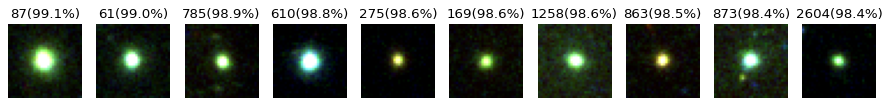

[Class 2] Objects: 197


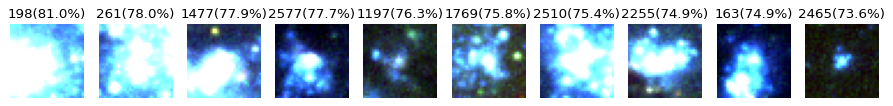

[Class 3] Objects: 240


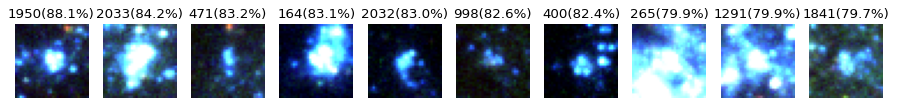

[Class 4] Objects: 1694


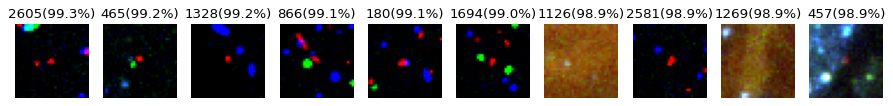

In [19]:
sz = 16 # patch size (i.e. sz x sz pixels)
num_objs = 10 # top-N objects to show

for class_label in range(4):
    class_ids = np.where(predictions == class_label)
    if len(class_ids[0]) == 0: 
        print('[Class %d] No objects predicted'%(class_label+1))
        continue
    scores_ids = softmax(scores, axis=1)[class_ids][:,class_label]
    sorted_ids = np.argsort(scores_ids)[::-1]
    
    print('[Class %d] Objects: %d'%(class_label+1,len(sorted_ids)))
    fig = plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
    for i in range(num_objs):
        if i >= len(class_ids[0]): continue
        plt.subplot(1,num_objs,i+1)
        plt.imshow(legus2rgb(data_all[class_ids][sorted_ids][i,:,:,:]))
        plt.title('%d(%.1f%%)'%(ids[class_ids[0][sorted_ids[i]]],scores_ids[sorted_ids[i]]*100))
        plt.axis('off')
    plt.show()
    
# Each image has as title the id and score [id(score)]